In [8]:
import kagglehub

# Download latest version
mypath = kagglehub.dataset_download("aymanmostafa11/eeg-motor-imagery-bciciv-2a")

print("Path to dataset files:", mypath)

Path to dataset files: /kaggle/input/eeg-motor-imagery-bciciv-2a


In [9]:
!pip install tensorflow
!pip install kagglehub

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_and_visualize(model, X_val, y_val, history, class_names):
    # Evaluate model
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation loss: {loss:.4f}")
    print(f"Validation accuracy: {acc:.4f}")

    # Predict classes
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [16]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=8, highcut=30, fs=250, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=-1)
    return y

def preprocess_data(dataset_path, time_steps=128, sliding_step=64, fs=250):
    target_classes = ['left', 'right', 'foot', 'tongue']
    filename = 'BCICIV_2a_all_patients.csv'
    filepath = os.path.join(dataset_path, filename)

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"{filename} not found in {dataset_path}")

    df = pd.read_csv(filepath)
    print(f"Original dataset samples: {len(df)}")

    # Filter labels
    df = df[df['label'].isin(target_classes)]
    print(f"Samples after label filtering: {len(df)}")
    if len(df) == 0:
        raise RuntimeError("No samples after filtering labels. Check label names.")

    eeg_cols = [col for col in df.columns if col.startswith('EEG')]
    print(f"EEG channels found: {len(eeg_cols)}")
    if len(eeg_cols) == 0:
        raise RuntimeError("No EEG columns found. Check column names.")

    # Create trial column if missing
    if 'trial' not in df.columns:
        # Assuming 'time' restarts each trial, detect trial boundaries
        df = df.sort_values(['patient', 'time'])
        df['trial'] = (df['time'].diff() < 0).cumsum()
        print("Added trial column based on time discontinuities.")

    X, y, patients = [], [], []

    for (trial, patient), group in df.groupby(['trial', 'patient']):
        trial_len = len(group)
        if trial_len < time_steps:
            print(f"Skipping trial {trial} (patient {patient}) with length {trial_len} < time_steps {time_steps}")
            continue

        trial_data = group[eeg_cols].values.T  # shape (channels, time)

        # Bandpass filter
        filtered = bandpass_filter(trial_data, lowcut=8, highcut=30, fs=fs)

        # Normalize per channel
        mean = filtered.mean(axis=1, keepdims=True)
        std = filtered.std(axis=1, keepdims=True) + 1e-6
        normed = (filtered - mean) / std

        start = 0
        while start + time_steps <= normed.shape[1]:
            segment = normed[:, start:start+time_steps]
            X.append(segment)
            y.append(group['label'].iloc[0])
            patients.append(patient)
            start += sliding_step

    if len(X) == 0:
        raise RuntimeError("No segments extracted. Try reducing time_steps or check data.")

    X = np.array(X)[..., np.newaxis]  # Add channel dimension
    y = LabelEncoder().fit_transform(y)
    y_onehot = to_categorical(y)
    patients = np.array(patients)

    print(f"Extracted {len(X)} segments with shape {X.shape}")
    return X, y_onehot, patients

Original dataset samples: 492048
Samples after label filtering: 492048
EEG channels found: 22
Added trial column based on time discontinuities.
Extracted 7657 segments with shape (7657, 22, 256, 1)
Data shape: (7657, 22, 256, 1), Labels shape: (7657, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 22, 256, 64)    │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 256, 64)     │        90,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 256, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 256, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 85, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 85, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 85, 128)     │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 85, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1, 85, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 28, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 28, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 28, 256)     │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 28, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1, 28, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684,291 (6.43 MB)

 Trainable params: 1,683,395 (6.42 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.00342, saving model to best_model.h5


37/37 - 61s - 2s/step - accuracy: 0.2933 - loss: 5.3872 - val_accuracy: 0.0034 - val_loss: 2.8178 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_accuracy did not improve from 0.00342
37/37 - 83s - 2s/step - accuracy: 0.2850 - loss: 2.8992 - val_accuracy: 0.0000e+00 - val_loss: 2.7275 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_accuracy improved from 0.00342 to 0.50213, saving model to best_model.h5


37/37 - 80s - 2s/step - accuracy: 0.3034 - loss: 2.7388 - val_accuracy: 0.5021 - val_loss: 2.0001 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_accuracy improved from 0.50213 to 0.63194, saving model to best_model.h5


37/37 - 82s - 2s/step - accuracy: 0.3958 - loss: 2.3404 - val_accuracy: 0.6319 - val_loss: 1.7688 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_accuracy improved from 0.63194 to 0.75662, saving model to best_model.h5


37/37 - 82s - 2s/step - accuracy: 0.5455 - loss: 1.8650 - val_accuracy: 0.7566 - val_loss: 1.6506 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_accuracy did not improve from 0.75662
37/37 - 53s - 1s/step - accuracy: 0.6164 - loss: 1.6910 - val_accuracy: 0.3868 - val_loss: 2.1032 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_accuracy did not improve from 0.75662
37/37 - 54s - 1s/step - accuracy: 0.7250 - loss: 1.4884 - val_accuracy: 0.4219 - val_loss: 2.3527 - learning_rate: 9.9958e-04
Epoch 8/200

Epoch 8: val_accuracy did not improve from 0.75662
37/37 - 82s - 2s/step - accuracy: 0.8079 - loss: 1.3335 - val_accuracy: 0.4321 - val_loss: 2.4121 - learning_rate: 1.8408e-05
Epoch 9/200

Epoch 9: val_accuracy did not improve from 0.75662
37/37 - 88s - 2s/step - accuracy: 0.8072 - loss: 1.3027 - val_accuracy: 0.4842 - val_loss: 2.2333 - learning_rate: 7.0725e-05
Epoch 10/200

Epoch 10: val_accuracy did not improve from 0.75662
37/37 - 77s - 2s/step - accuracy: 0.8493 - loss:

37/37 - 57s - 2s/step - accuracy: 0.9411 - loss: 1.0123 - val_accuracy: 0.8523 - val_loss: 1.2829 - learning_rate: 5.3975e-04
Epoch 16/200

Epoch 16: val_accuracy did not improve from 0.85226
37/37 - 78s - 2s/step - accuracy: 0.9560 - loss: 0.9608 - val_accuracy: 0.6661 - val_loss: 2.1100 - learning_rate: 6.6456e-04
Epoch 17/200

Epoch 17: val_accuracy did not improve from 0.85226
37/37 - 85s - 2s/step - accuracy: 0.9562 - loss: 0.9327 - val_accuracy: 0.5798 - val_loss: 3.3579 - learning_rate: 9.9973e-04
Epoch 18/200

Epoch 18: val_accuracy improved from 0.85226 to 0.96413, saving model to best_model.h5


37/37 - 80s - 2s/step - accuracy: 0.9682 - loss: 0.8879 - val_accuracy: 0.9641 - val_loss: 0.9010 - learning_rate: 2.4941e-04
Epoch 19/200

Epoch 19: val_accuracy did not improve from 0.96413
37/37 - 84s - 2s/step - accuracy: 0.9851 - loss: 0.8388 - val_accuracy: 0.8463 - val_loss: 1.2751 - learning_rate: 2.7019e-04
Epoch 20/200

Epoch 20: val_accuracy did not improve from 0.96413
37/37 - 80s - 2s/step - accuracy: 0.9774 - loss: 0.8377 - val_accuracy: 0.7096 - val_loss: 1.8867 - learning_rate: 6.9197e-04
Epoch 21/200

Epoch 21: val_accuracy did not improve from 0.96413
37/37 - 54s - 1s/step - accuracy: 0.9889 - loss: 0.8079 - val_accuracy: 0.7165 - val_loss: 1.8598 - learning_rate: 1.3757e-05
Epoch 22/200

Epoch 22: val_accuracy did not improve from 0.96413
37/37 - 83s - 2s/step - accuracy: 0.9716 - loss: 0.8266 - val_accuracy: 0.8471 - val_loss: 1.1099 - learning_rate: 9.9646e-04
Epoch 23/200

Epoch 23: val_accuracy did not improve from 0.96413
37/37 - 81s - 2s/step - accuracy: 0.9637

37/37 - 82s - 2s/step - accuracy: 0.9870 - loss: 0.6973 - val_accuracy: 0.9821 - val_loss: 0.6907 - learning_rate: 9.9978e-04
Epoch 26/200

Epoch 26: val_accuracy did not improve from 0.98207
37/37 - 83s - 2s/step - accuracy: 0.9919 - loss: 0.6570 - val_accuracy: 0.8309 - val_loss: 1.1396 - learning_rate: 5.3757e-04
Epoch 27/200

Epoch 27: val_accuracy did not improve from 0.98207
37/37 - 80s - 2s/step - accuracy: 0.9893 - loss: 0.6424 - val_accuracy: 0.4475 - val_loss: 5.6267 - learning_rate: 9.5489e-04
Epoch 28/200

Epoch 28: val_accuracy did not improve from 0.98207
37/37 - 81s - 2s/step - accuracy: 0.9853 - loss: 0.6336 - val_accuracy: 0.7071 - val_loss: 1.8087 - learning_rate: 3.4819e-04
Epoch 29/200

Epoch 29: val_accuracy did not improve from 0.98207
37/37 - 56s - 2s/step - accuracy: 0.9932 - loss: 0.6046 - val_accuracy: 0.8147 - val_loss: 1.2231 - learning_rate: 1.6462e-04
Epoch 30/200

Epoch 30: val_accuracy did not improve from 0.98207
37/37 - 80s - 2s/step - accuracy: 0.9962

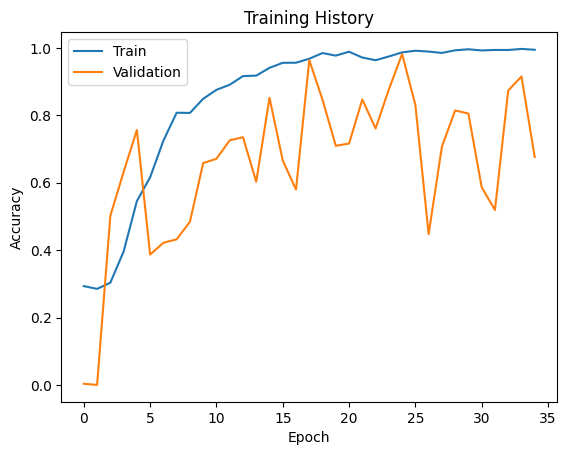

In [17]:

def evaluate_and_visualize(model, X_val, y_val, history, class_names):
    # Evaluate model
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation loss: {loss:.4f}")
    print(f"Validation accuracy: {acc:.4f}")

    # Predict classes
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# === DeepConvNet Architecture ===
def build_deep_convnet(input_shape, num_classes):
    model = tf.keras.Sequential([
        # Block 1
        Conv2D(64, (1, 10), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        Conv2D(64, (input_shape[0], 1), padding='valid', use_bias=False),  # Spatial convolution - Changed len(input_shape[0]) to input_shape[0]
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((1, 3)),
        Dropout(0.5),

        # Block 2
        Conv2D(128, (1, 10), padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((1, 3)),
        Dropout(0.5),

        # Block 3
        Conv2D(256, (1, 10), padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('elu'),
        MaxPooling2D((1, 3)),
        Dropout(0.5),

        Flatten(),
        Dense(512, activation='elu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# === Learning Rate Schedule ===
def cosine_decay(epoch, total_epochs=200):
    return 0.5 * (1 + np.cos(np.pi * epoch / total_epochs)) * 0.001

# === Main Pipeline ===
if __name__ == "__main__":
    # Parameters
    dataset_path = mypath
    time_steps = 256  # ~1 second at 250Hz
    sliding_step = 64

    # Load and preprocess
    X, y, patients = preprocess_data(dataset_path, time_steps, sliding_step)
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

    # Class weights
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y.argmax(1)), y=y.argmax(1))
    class_weights = dict(enumerate(class_weights))

    # Subject-wise split
    gss = GroupShuffleSplit(test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y.argmax(1), groups=patients))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Build model
    model = build_deep_convnet(X_train.shape[1:], y.shape[1])
    model.summary()

    # Callbacks
    callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    LearningRateScheduler(cosine_decay)
      ]

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=128,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=2
    )

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"Final Test Accuracy: {test_acc:.4f}")

    # Plot training history
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Training History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


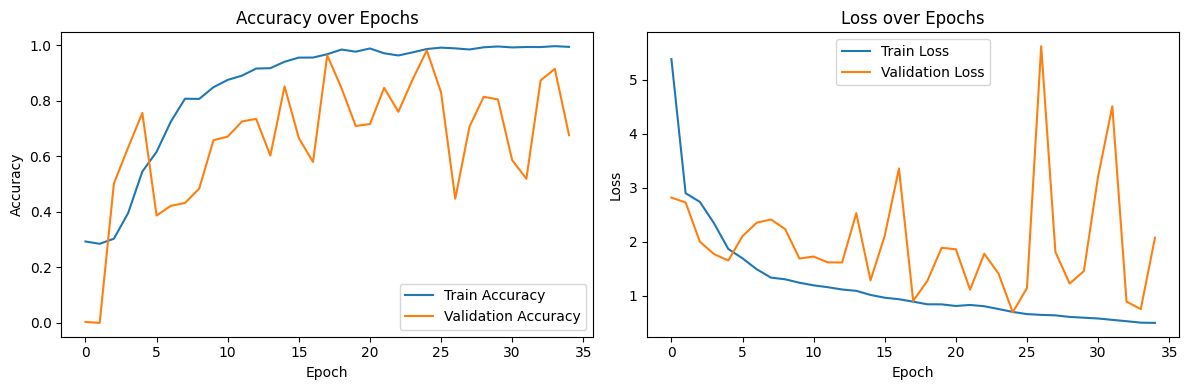

In [18]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
